In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

import tensorflow as tf

# Scikit-learn classifiers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import itertools

# Imports for MIA
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from scipy import special

%matplotlib inline

MIA Function definition for sklearn models using TF-Privacy

In [67]:
def membership_inference_attack(model, X_train, X_test, y_train, y_test):

    prob_train = model.predict_proba(X_train)
    prob_test = model.predict_proba(X_test)

    print('Compute losses...')
    cce = tf.keras.backend.categorical_crossentropy
    constant = tf.keras.backend.constant

    # This might be a bit of a stretch: using categorical crossentropy for all classifiers
    loss_train = cce(constant(np.eye(2)[y_train]), constant(prob_train), from_logits=False).numpy()
    loss_test = cce(constant(np.eye(2)[y_test]), constant(prob_test), from_logits=False).numpy()

    input = AttackInputData(
      probs_train = prob_train,
      probs_test = prob_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = y_train,
      labels_test = y_test
    )

    # Run several attacks for different data slices
    attacks_result = mia.run_attacks(input,
                                     SlicingSpec(
                                         entire_dataset = True,
                                         by_class = True,
                                         by_classification_correctness = True
                                     ),
                                     attack_types = [
                                         AttackType.THRESHOLD_ATTACK,
                                         AttackType.LOGISTIC_REGRESSION,
                                         AttackType.MULTI_LAYERED_PERCEPTRON,
                                         AttackType.RANDOM_FOREST, 
                                         AttackType.K_NEAREST_NEIGHBORS,
                                         #AttackType.THRESHOLD_ENTROPY_ATTACK
                                     ])

    # Plot the ROC curve of the best classifier
    fig = plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    plt.show()
    # Print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices = True))
    return attacks_result.get_result_with_max_auc().get_auc(), attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

Generate random classification data for testing

In [71]:
n_classes = 2
X, y = make_classification(n_samples=12000, n_classes=n_classes, random_state=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

In [72]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", probability=True, C=0.025),
    SVC(gamma=2, probability=True, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

Training classifier Nearest Neighbors...
Nearest Neighbors obtained an accuracy of 0.8568181818181818
Compute losses...


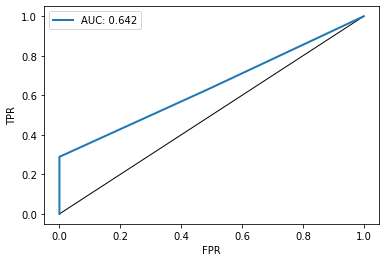

Best-performing attacks over all slices
  RANDOM_FOREST (with 567 training and 567 test examples) achieved an AUC of 0.64 on slice CORRECTLY_CLASSIFIED=False
  RANDOM_FOREST (with 567 training and 567 test examples) achieved an advantage of 0.29 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an AUC of 0.56
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an advantage of 0.09

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an AUC of 0.56
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an advantage of 0.10

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1993 training and 1993 test examples) achieved an AUC of 0.57
  LOGISTIC_REGRESSION (with 1993 training and 1993 test examples) achieved an advantage of 0.11

Best-performing attacks

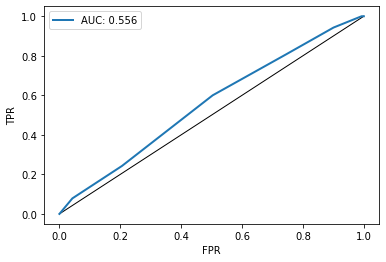

Best-performing attacks over all slices
  K_NEAREST_NEIGHBORS (with 561 training and 561 test examples) achieved an AUC of 0.56 on slice CORRECTLY_CLASSIFIED=False
  RANDOM_FOREST (with 561 training and 561 test examples) achieved an advantage of 0.11 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an AUC of 0.51
  THRESHOLD_ATTACK (with 8040 training and 3960 test examples) achieved an advantage of 0.04

Best-performing attacks over slice: "CLASS=0"
  K_NEAREST_NEIGHBORS (with 1967 training and 1967 test examples) achieved an AUC of 0.54
  K_NEAREST_NEIGHBORS (with 1967 training and 1967 test examples) achieved an advantage of 0.07

Best-performing attacks over slice: "CLASS=1"
  RANDOM_FOREST (with 1993 training and 1993 test examples) achieved an AUC of 0.51
  MULTI_LAYERED_PERCEPTRON (with 1993 training and 1993 test examples) achieved an advantage of 0.07

Best

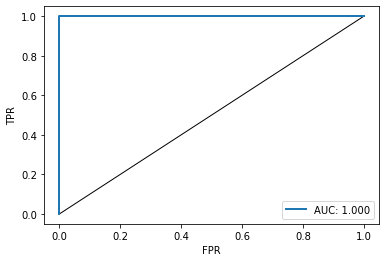

Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 3960 training and 3960 test examples) achieved an AUC of 1.00 on slice Entire dataset
  THRESHOLD_ATTACK (with 8040 training and 3960 test examples) achieved an advantage of 1.00 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 3960 training and 3960 test examples) achieved an AUC of 1.00
  THRESHOLD_ATTACK (with 8040 training and 3960 test examples) achieved an advantage of 1.00

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples)

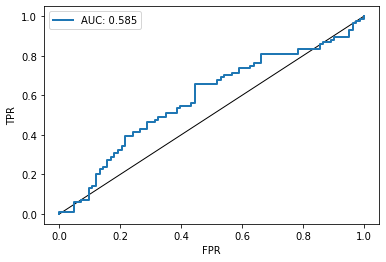

Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 333 training and 333 test examples) achieved an AUC of 0.58 on slice CORRECTLY_CLASSIFIED=False
  MULTI_LAYERED_PERCEPTRON (with 333 training and 333 test examples) achieved an advantage of 0.21 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an AUC of 0.54
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an advantage of 0.07

Best-performing attacks over slice: "CLASS=0"
  RANDOM_FOREST (with 1967 training and 1967 test examples) achieved an AUC of 0.54
  RANDOM_FOREST (with 1967 training and 1967 test examples) achieved an advantage of 0.09

Best-performing attacks over slice: "CLASS=1"
  RANDOM_FOREST (with 1993 training and 1993 test examples) achieved an AUC of 0.54
  RANDOM_FOREST (with 1993 training and 1993 test examples) achieved an advantage of 0.09

Best-performin

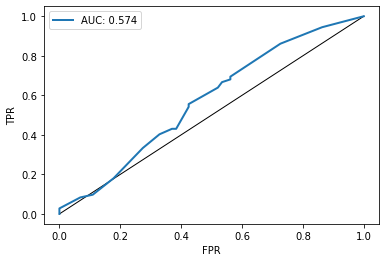

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 290 training and 290 test examples) achieved an AUC of 0.57 on slice CORRECTLY_CLASSIFIED=False
  RANDOM_FOREST (with 290 training and 290 test examples) achieved an advantage of 0.17 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an AUC of 0.52
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=0"
  RANDOM_FOREST (with 1967 training and 1967 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1993 training and 1993 test examples) achieved an AUC of 0.55
  LOGISTIC_REGRESSION (with 1993 training and 1993 test examples) achieved an advantage of 0.08

Best-performing attacks

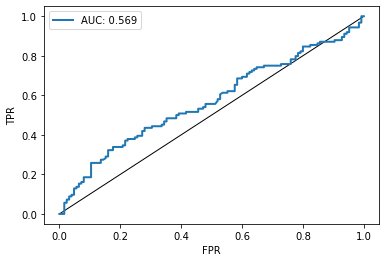

Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 498 training and 498 test examples) achieved an AUC of 0.57 on slice CORRECTLY_CLASSIFIED=False
  MULTI_LAYERED_PERCEPTRON (with 498 training and 498 test examples) achieved an advantage of 0.16 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an AUC of 0.54
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an advantage of 0.08

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an AUC of 0.56
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an advantage of 0.12

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 4004 training and 1993 test examples) achieved an AUC of 0.52
  LOGISTIC_REGRESSION (with 1993 training and 1993 test examples) achieved an a

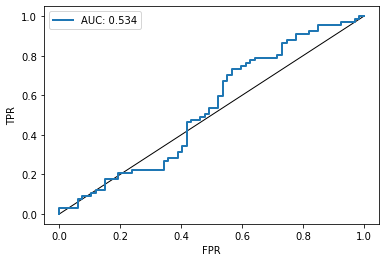

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 267 training and 267 test examples) achieved an AUC of 0.53 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 267 training and 267 test examples) achieved an advantage of 0.16 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  K_NEAREST_NEIGHBORS (with 3960 training and 3960 test examples) achieved an AUC of 0.51
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an AUC of 0.53
  LOGISTIC_REGRESSION (with 1967 training and 1967 test examples) achieved an advantage of 0.08

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 4004 training and 1993 test examples) achieved an AUC of 0.50
  RANDOM_FOREST (with 1993 training and 1993 test examples) achieved an advantage of 0.08

Bes

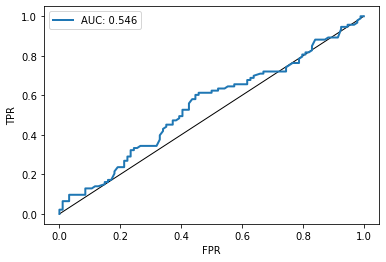

Best-performing attacks over all slices
  RANDOM_FOREST (with 374 training and 374 test examples) achieved an AUC of 0.55 on slice CORRECTLY_CLASSIFIED=False
  RANDOM_FOREST (with 374 training and 374 test examples) achieved an advantage of 0.16 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an AUC of 0.52
  RANDOM_FOREST (with 3960 training and 3960 test examples) achieved an advantage of 0.04

Best-performing attacks over slice: "CLASS=0"
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an AUC of 0.52
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an advantage of 0.09

Best-performing attacks over slice: "CLASS=1"
  K_NEAREST_NEIGHBORS (with 1993 training and 1993 test examples) achieved an AUC of 0.54
  MULTI_LAYERED_PERCEPTRON (with 1993 training and 1993 test examples) achieved an advantage of 0.07

Best-per

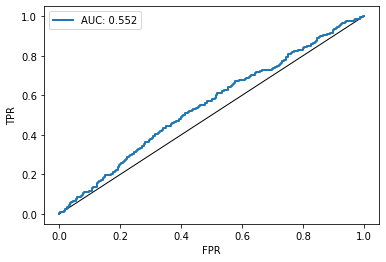

Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an AUC of 0.55 on slice CLASS=0
  LOGISTIC_REGRESSION (with 502 training and 502 test examples) achieved an advantage of 0.13 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  K_NEAREST_NEIGHBORS (with 3960 training and 3960 test examples) achieved an AUC of 0.53
  K_NEAREST_NEIGHBORS (with 3960 training and 3960 test examples) achieved an advantage of 0.05

Best-performing attacks over slice: "CLASS=0"
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an AUC of 0.55
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an advantage of 0.10

Best-performing attacks over slice: "CLASS=1"
  MULTI_LAYERED_PERCEPTRON (with 1993 training and 1993 test examples) achieved an AUC of 0.52
  LOGISTIC_REGRESSION (with 1993 training and 1993 test examples) achieved an advantage of 0.

C:\Users\Usuario\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


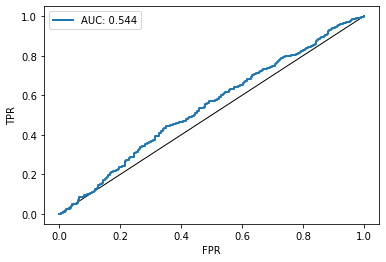

Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an AUC of 0.54 on slice CLASS=0
  MULTI_LAYERED_PERCEPTRON (with 615 training and 615 test examples) achieved an advantage of 0.16 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an AUC of 0.52
  MULTI_LAYERED_PERCEPTRON (with 3960 training and 3960 test examples) achieved an advantage of 0.05

Best-performing attacks over slice: "CLASS=0"
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an AUC of 0.54
  MULTI_LAYERED_PERCEPTRON (with 1967 training and 1967 test examples) achieved an advantage of 0.09

Best-performing attacks over slice: "CLASS=1"
  RANDOM_FOREST (with 1993 training and 1993 test examples) achieved an AUC of 0.52
  RANDOM_FOREST (with 1993 training and 1993 test examples) achieved an advantage of 0.06

In [73]:
for name, clf in zip(names, classifiers):
    print(f'Training classifier {name}...')
    clf.fit(X_train, y_train)   
    score = clf.score(X_test, y_test)
    print(f'{name} obtained an accuracy of {score}')
    auc, adv = membership_inference_attack(clf, X_train, X_test, y_train, y_test)
    print(f'Max AUC for MIA is {auc}. Max attacker advantage is {adv}')
